<div align="center" style="line-height: 1.7;">
    <h2 style="font-weight: 600;"><strong>Dyna-Q in GridWorld</strong></h2>
</div> 

&nbsp;

**Goal:** Learn a high-quality policy by combining **real experience** (TD control) with planning from a learned **one-step model**.

---

### Why Dyna-Q?
**Dyna-Q** augments standard model-free learning (like Q-Learning) with **simulated updates** drawn from a simple learned model **$M$** of the environment. After each real step, it performs **$K$ planning updates** by sampling previously seen $(s, a)$ pairs, querying **$M$** for $(r, s', done)$, and applying the **same TD backup** you'd use on real data. This typically improves **sample efficiency** (faster learning in fewer real steps).

---

### Interaction Loop (real + planning)
At each time step the agent:

1. Observes current state $(s)$
2. Chooses action $(a \sim \pi_\epsilon(\cdot \mid s)$ $(\varepsilon\text{-greedy})$
3. Receives reward $(r)$, transitions to $(s')$ (real environment)
4. **Real TD update** on $Q(s, a)$
5. **Model Update:** store / refresh  $\hat{r}(s, a), \hat{s}'(s, a), \hat{d}(s, a)$
6. **Planning:** for $(K = 1...K)$, sample a previously seen $(\tilde{s}, \tilde{a})$, query the model for $(\tilde{r}, \tilde{s}', \tilde{d})$, and apply a TD update to $Q(\tilde{s}, \tilde{a})$

The **return** is the discounted sum of future rewards,

$$
G_t = \sum_{k=0}^\infty \gamma^k R_{t+k+1}
$$

with discount $\gamma \in [0, 1]$ controlling farsightedness.

---

### Action-Value Function & Backup

Dyna-Q learns the **action-value function** $Q(s, a)$: expected return starting ini $(s)$, taking $(a)$, and thereafter following the (greedy/$\varepsilon\text{-greedy}$) control policy.
We use the **Q-Learning (off-policy) target** for both real and model steps:

$$
\boxed{~~
Q(s, a) \leftarrow Q(s, a) + \alpha \Big[\, r + \gamma \max{a'} Q(s', a') - Q(s, a) \, \Big]
~~}
$$

- **Real update:** $(s, a, r, s', d)$ comes from the environment.
- **Planning update(s):** $(\tilde{s}, \tilde{a}, \tilde{r}, \tilde{s}', \tilde{d})$ come from the **model** $(\hat{\mathcal M})$

If we had the true optimal $Q^\star$, the greedy action would be

$$
\pi^\star(s) = \arg\max_a Q^\star(s, a).
$$

---

### Symbol

| Symbol | Meaning |
|---|---|
| $(s, a)$ | Current state and action |
| $(r)$ | Reward after taking $(a)$ in $(s)$ |
| $(s')$ | Next state |
| $(\alpha)$ | Learning rate |
| $(\gamma)$ | Discount factor |
| $(K)$ | `planning_steps`: number of simulated updates per real step |
| $(\hat{\mathcal M})$ | Learned one-step model storing last-seen $(r, s', \text{done}$ per $(s,a)$ |
| TD error | $\delta = r + \gamma \max_{a'} Q(s',a') - Q(s,a)$ |

---


### Exploration vs Exploitation

Behavior policy is **$\varepsilon\text{-greedy}$:**

- With probability $(\epsilon)$: pick a random action (explore)
- With probability $(1 - \epsilon)$: pick $\arg\max_a Q(s, a)$ (exploitation)

$(\epsilon)$ typically **decays** from 1.0 to a small floor so early training explores widely and later focuses on exploitation.

---

### Intuitive Summary

| Concept | Analogy |
|---|---|
| Q-table | A map: how good each move is in each state |
| Model \(\hat{\mathcal M}\) | A notebook of “what happened last time we tried \((s,a)\)” |
| Planning | “Imaginary practice” using the notebook to reinforce the map |
| TD Error | Surprise: how different reality/model was from our prediction |
| \(K\) (planning steps) | How many extra practice reps per real step |

**Heuristic.** With a modest $(K)$ (e.g., 5–20), Dyna-Q often reaches strong policies **sooner** than pure Q-Learning, especially when real interactions are costly. Larger $(K)$ speeds early learning but can overemphasize stale model entries balance is key.

## 1) Import & Environment Setup
This section imports all the necessary code and libraries. (There will be an `environment setup` in every notebook, it is necessary for the correct functioning of the algorithms and future analysis)

In [9]:
# --- Notebook Setup ----------------------------------------------------
import sys, os
from pathlib import Path
from IPython import get_ipython
import importlib
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
import numpy as np

GREEN = "\033[92m"; RED = "\033[91m"; RESET = "\033[0m"

try:
    root = Path.cwd()
    src_path = (root / "../src").resolve()

    # 1) Make sure local ../src wins over site-packages
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    ip = get_ipython()
    if ip:
        ip.run_line_magic("load_ext", "autoreload")
        ip.run_line_magic("autoreload", "2")

    # 2) Import and *verify* we’re loading the right files
    import rl_capstone
    import rl_capstone.rl_algorithms as rla
    print("rl_capstone from:", getattr(rl_capstone, "__file__", "?"))
    print("rl_algorithms from:", getattr(rla, "__file__", "?"))

    # 3) Force a reload in case kernel already loaded the old one
    importlib.reload(rla)

    # 4) Now import the names (after reload)
    from rl_capstone import GridWorld, WorldSettings
    from rl_capstone.rl_algorithms import TrainConfig, dyna_q_train_with_logs
    from rl_capstone.utils import (
    evaluate_policy,
    greedy_policy_from_0,
    plot_learning_curve,
    EpisodeLog,
    greedy_action,
    run_greedy_episode,
    rolling,
    idx_traj_to_rc_path,
    value_grid,
    plot_value_and_policy,
)

    print(f"{GREEN}Environment setup complete!{RESET}")

except Exception as e:
    print(f"{RED}Setup failed:{RESET}", e)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
rl_capstone from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/__init__.py
rl_algorithms from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/rl_algorithms.py
Environment setup complete!


## 2) Build & Preview the environment
This section is for visualization purposes, the user can see the world where the agent will be performing its tasks, this can be changed by the user by adding walls, pits, changing the position of the starting point and the goal, as well as the size of the Grid World.

(For more information on how to use the `GridWorld` class please check: [GridWorld](../src/rl_capstone/rl_algorithms.py))


States=121, Actions=4, Grid=11x11



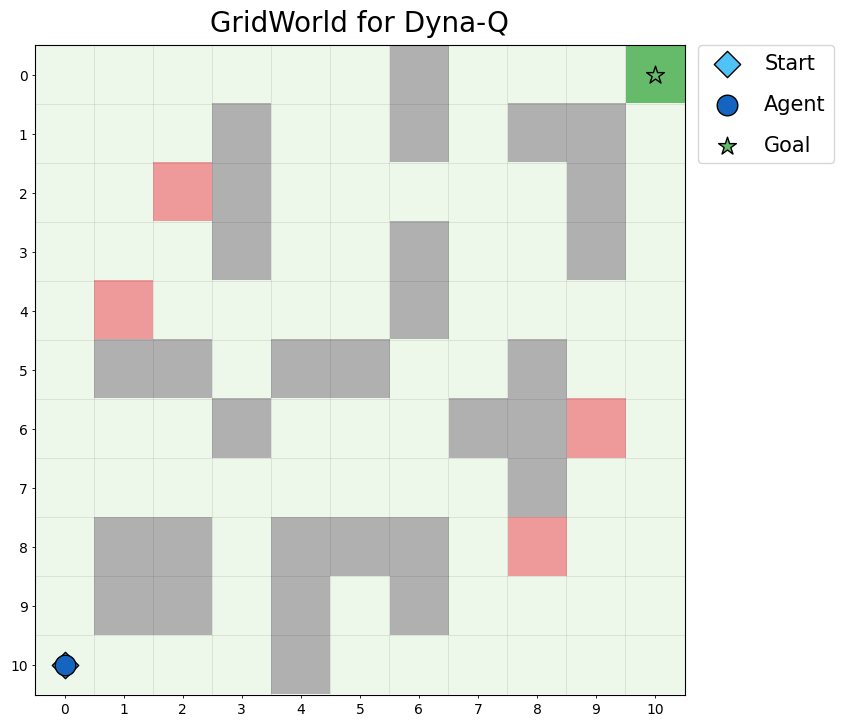

In [10]:
# Instantiate environment with  WorldSettings
settings = WorldSettings()  # Default map
env = GridWorld(settings)
env.seed(7)

print(f"\nStates={env.num_states}, Actions={env.num_actions}, Grid={env.rows}x{env.cols}\n")

env.render(title="GridWorld for Dyna-Q")

## 3) Log Config

This section controls how often the log training progress is and how many episodes are run to measure greedy performance at each snapshot.

Users can change the limit of snapshots, episodes and seed, which will affect factors like: `Wind randomness`, `Transition noise`, `Length and returns of greedy evaluation episodes`.

In [11]:
# Tweak depending on user preferences
@dataclass
class LogConfig:
    snapshot_every: int = 40    # take a snapshot every N episodes
    eval_episodes: int = 5      # greedy evals per snapshot
    seed: Optional[int] = 7

print(f"{GREEN}Log Config Setup!{RESET}")

Log Config Setup!


## 4) Train Configuration Dyna-Q & Plot Learning Curves

In this section the user can set up the configurations needed for training the agent. As well as visualize how the agent is learning by plotting a `Learning Curve`, which shows the number of episodes with respect to the `Return` the agent experienced in the algorithm with the respective configurations.

In [12]:
# Same constants as other models
cfg = TrainConfig(
    episodes=750,
    max_steps=1000,
    alpha=0.10,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_steps=10_000,
    seed=42,
    q_init=0.0
)

logcfg = LogConfig(snapshot_every=40, eval_episodes=5, seed=7)

Q_dyna, logs_dyna = dyna_q_train_with_logs(env, cfg, logcfg)
print(f"{GREEN}Dyna-Q Training complete.{RESET}")

Dyna-Q Training complete.



Evaluation — mean return over 30 episodes: 0.779, mean steps: 23.1



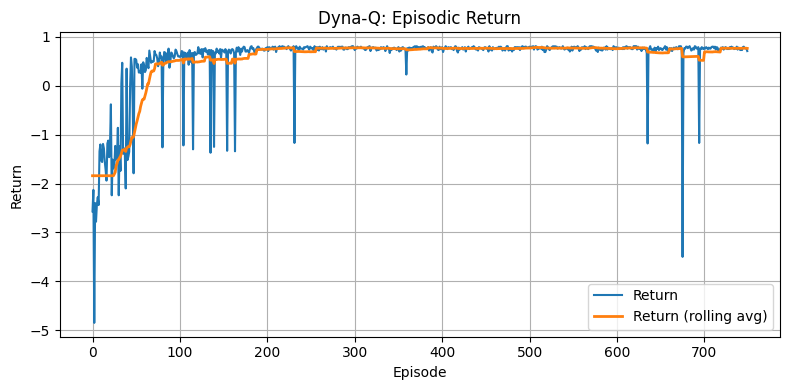

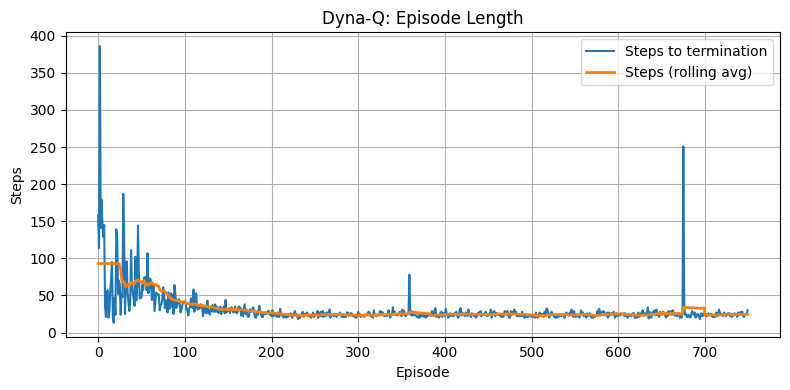

In [17]:
pi_sarsa = greedy_policy_from_0(Q_dyna)
mean_return, mean_len = evaluate_policy(env, pi_sarsa, episodes=30, max_steps=1000, seed=123)
print(f"\nEvaluation — mean return over 30 episodes: {mean_return:.3f}, mean steps: {mean_len:.1f}\n")

# --- Dyna-q: Return Curve ----
plt.figure(figsize=(8,4))
plt.plot(logs_dyna["returns"], label="Return")
plt.plot(rolling(logs_dyna["returns"], 25), label="Return (rolling avg)", linewidth=2)
plt.title("Dyna-Q: Episodic Return"); plt.xlabel("Episode"); plt.ylabel("Return")
plt.grid(True); plt.legend();

plt.tight_layout()
plt.savefig("../reports/figs/dyna_q/dynaq_return.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Dyna-Q: Episode Length --
plt.figure(figsize=(8,4))
plt.plot(logs_dyna["steps"], label="Steps to termination")
plt.plot(rolling(logs_dyna["steps"], 25), label="Steps (rolling avg)", linewidth=2)
plt.title("Dyna-Q: Episode Length"); plt.xlabel("Episode"); plt.ylabel("Steps")
plt.grid(True); plt.legend();

plt.tight_layout()
plt.savefig("../reports/figs/dyna_q/dynaq_steps.png", dpi=300, bbox_inches="tight")
plt.show()


## 5) Snapshots of Agent's Trajectory
This section converts each trajectory of state indices into `(row, col)` and overlay it as a path.
This gives you **several images** across training showing the agent getting better.

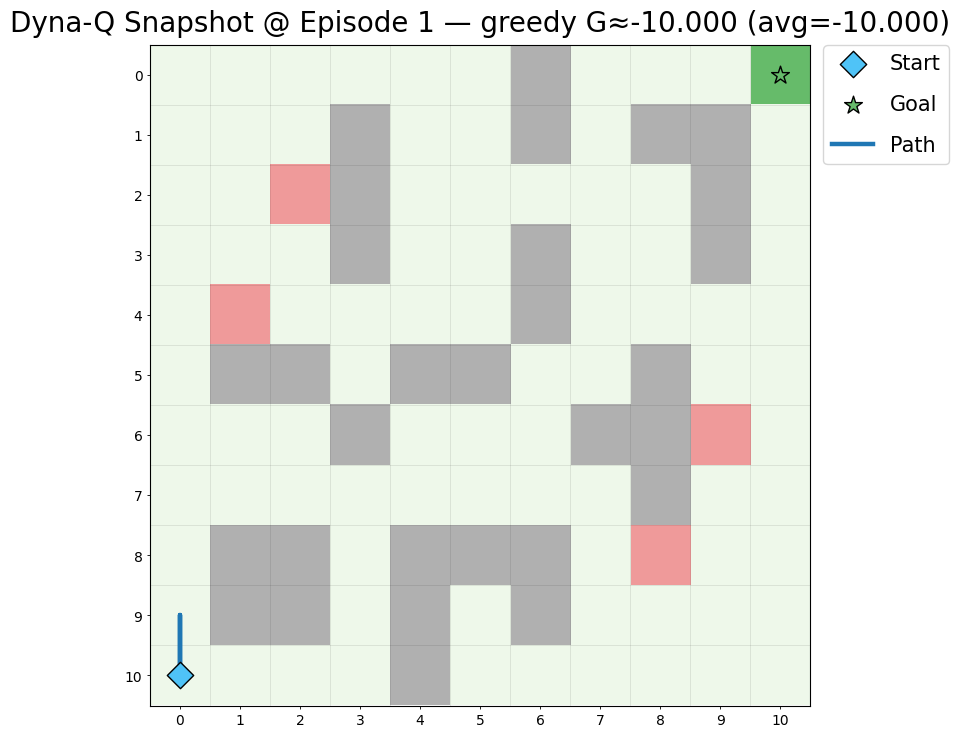

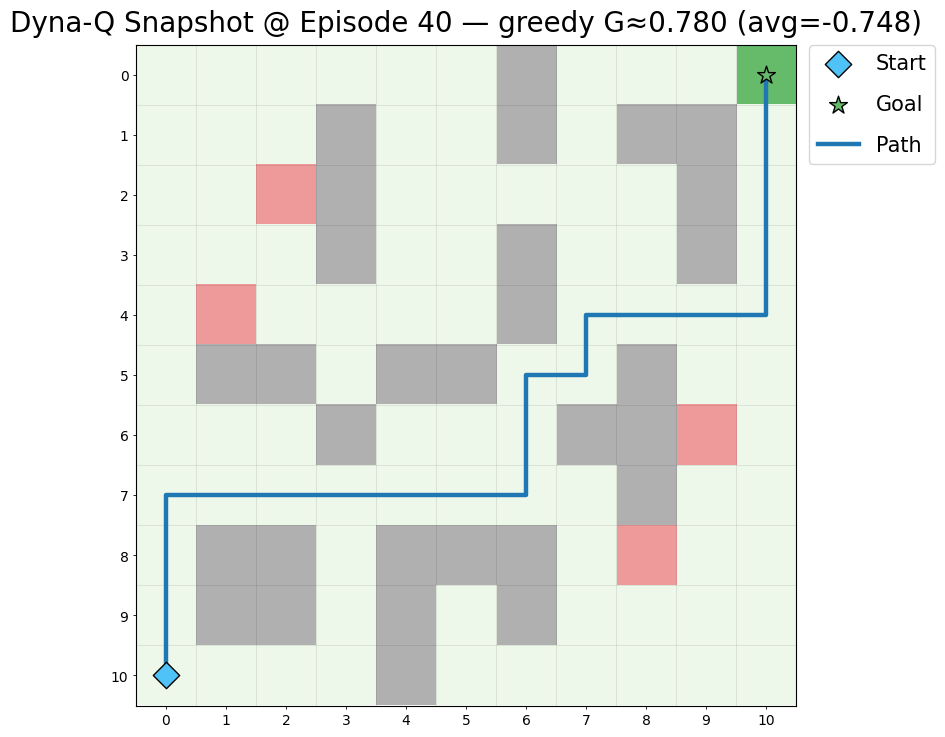

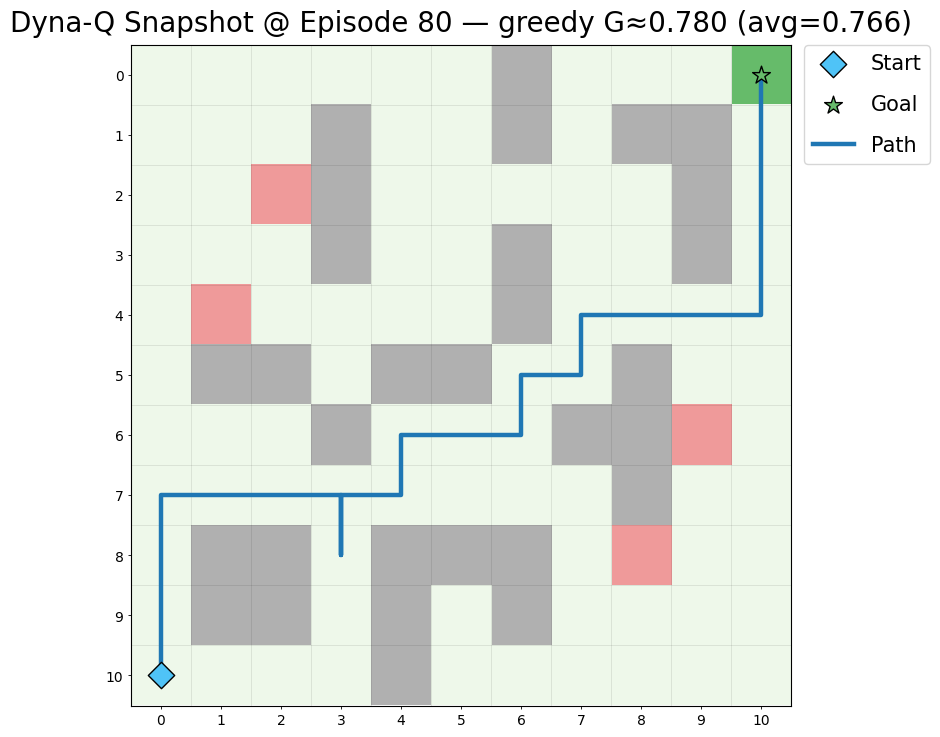

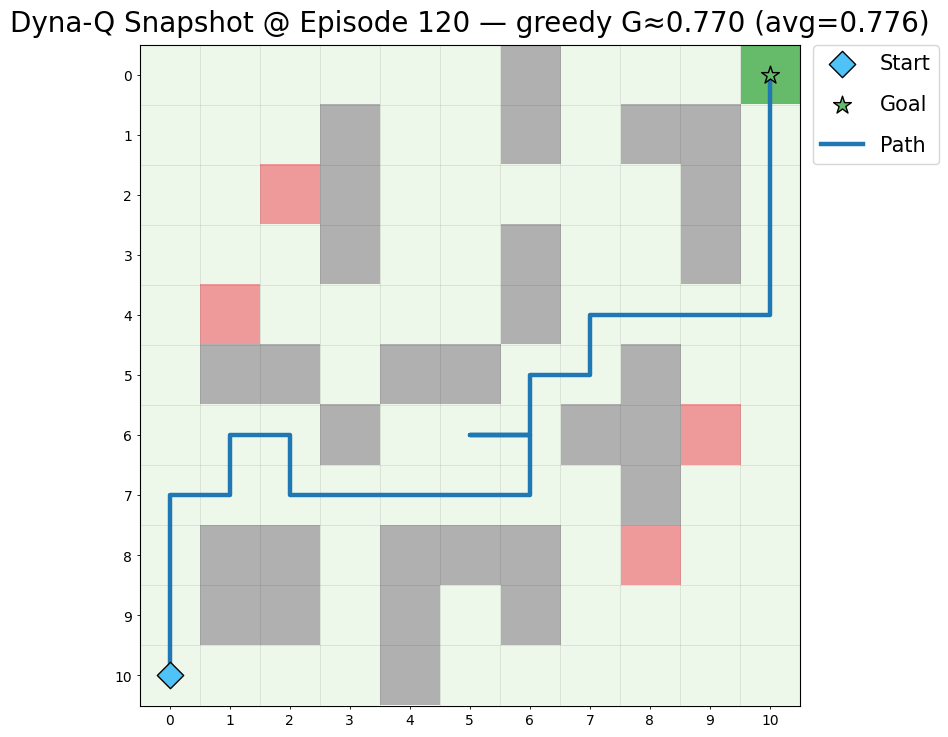

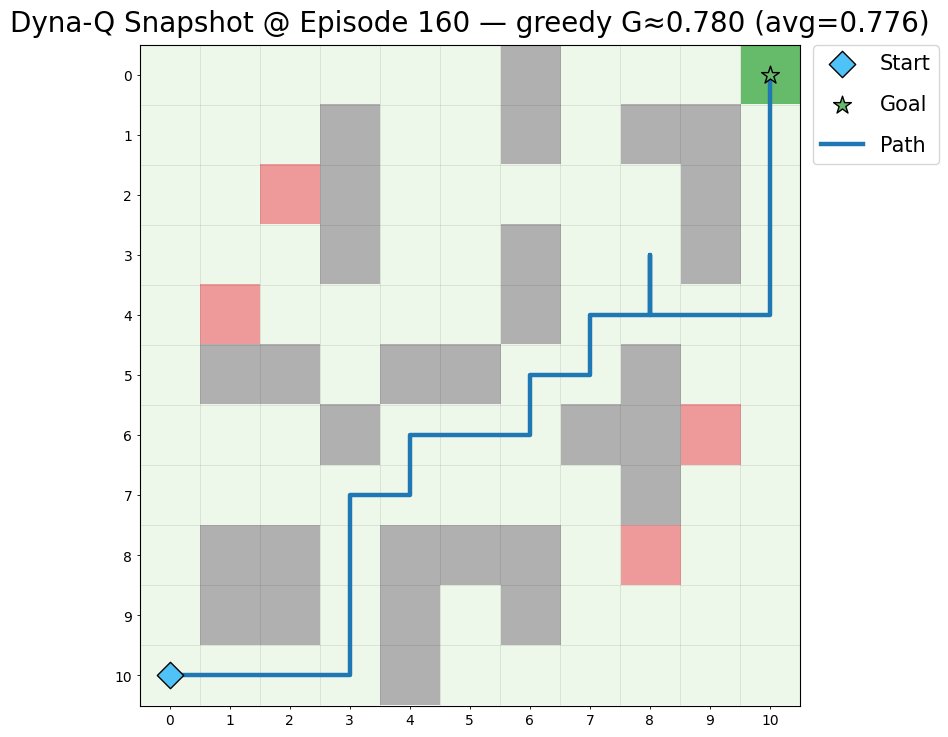

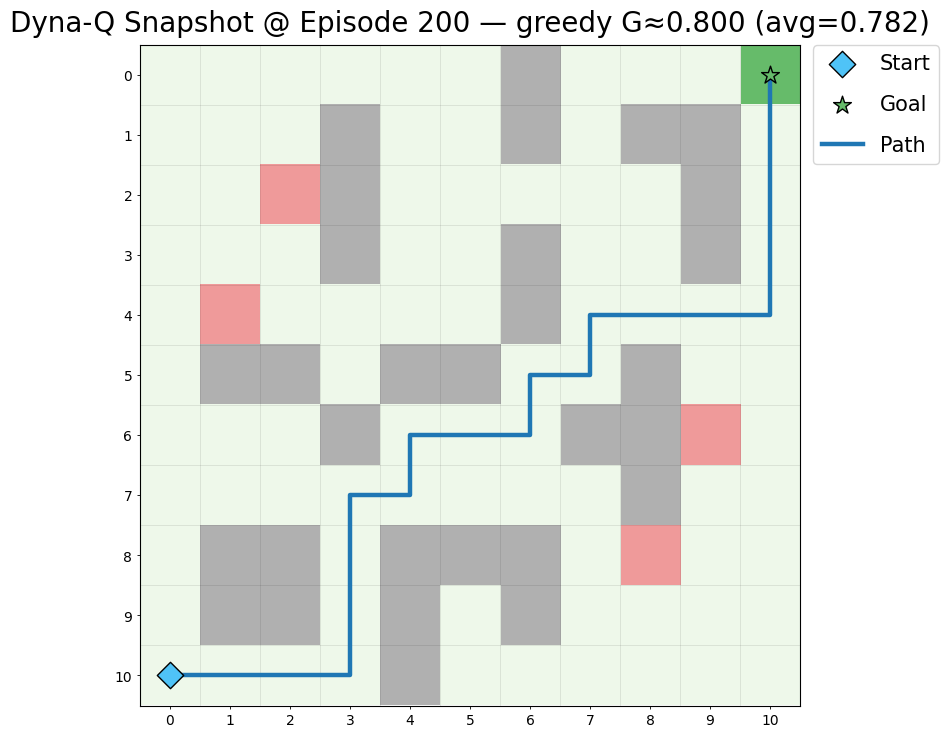

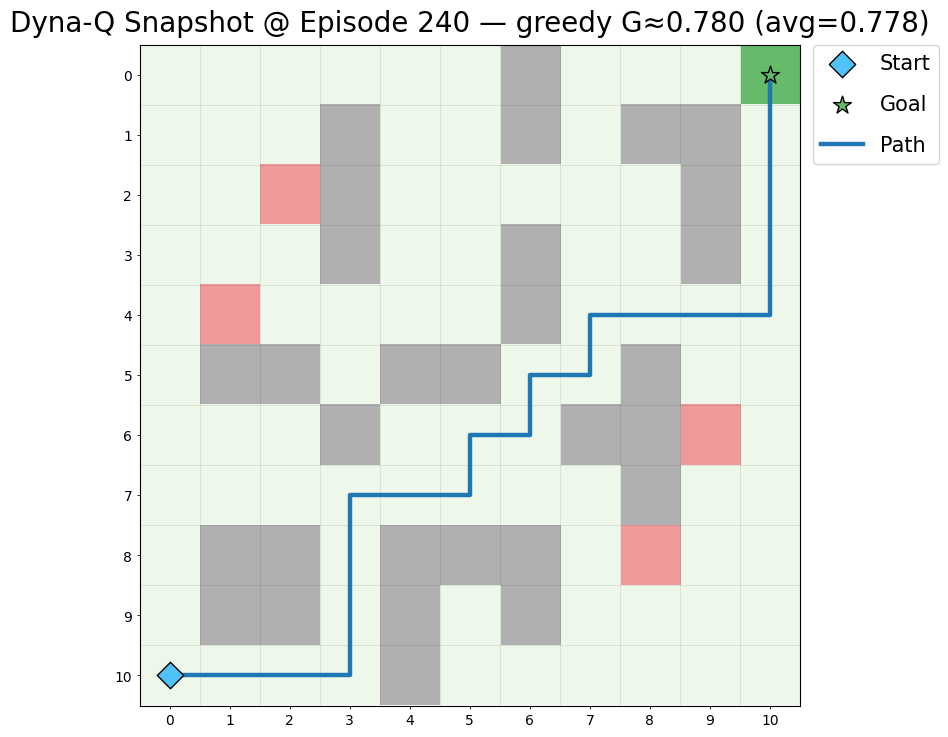

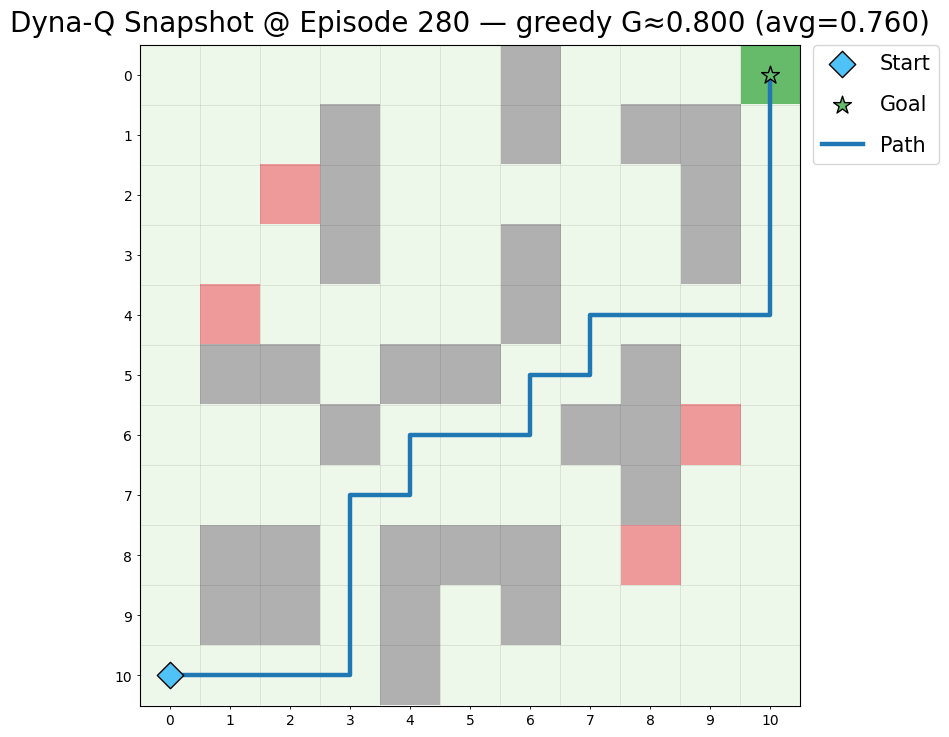

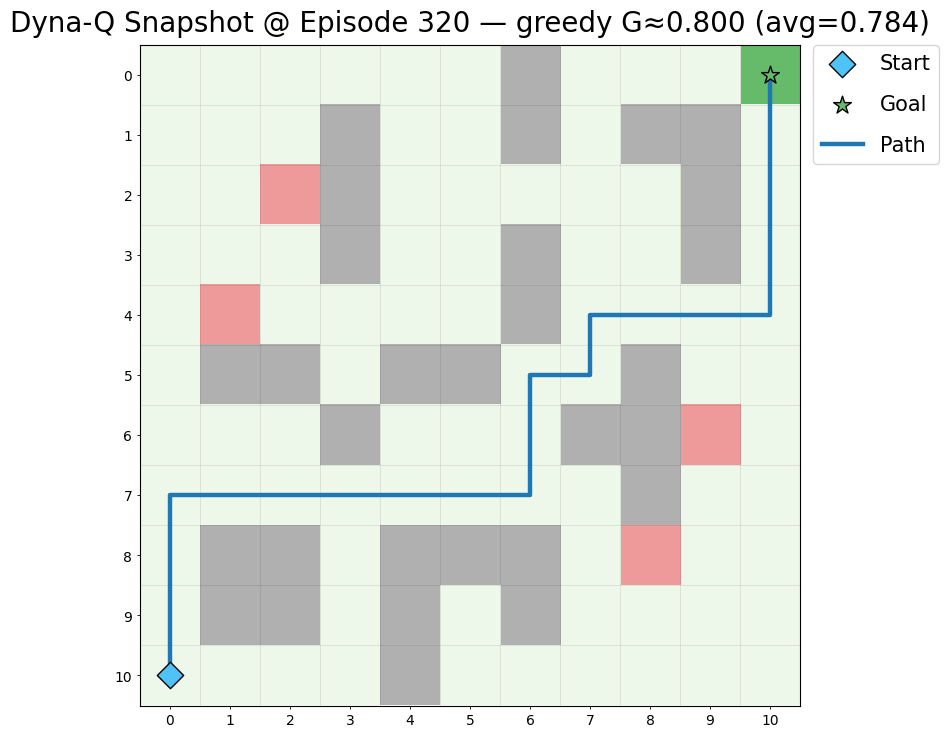

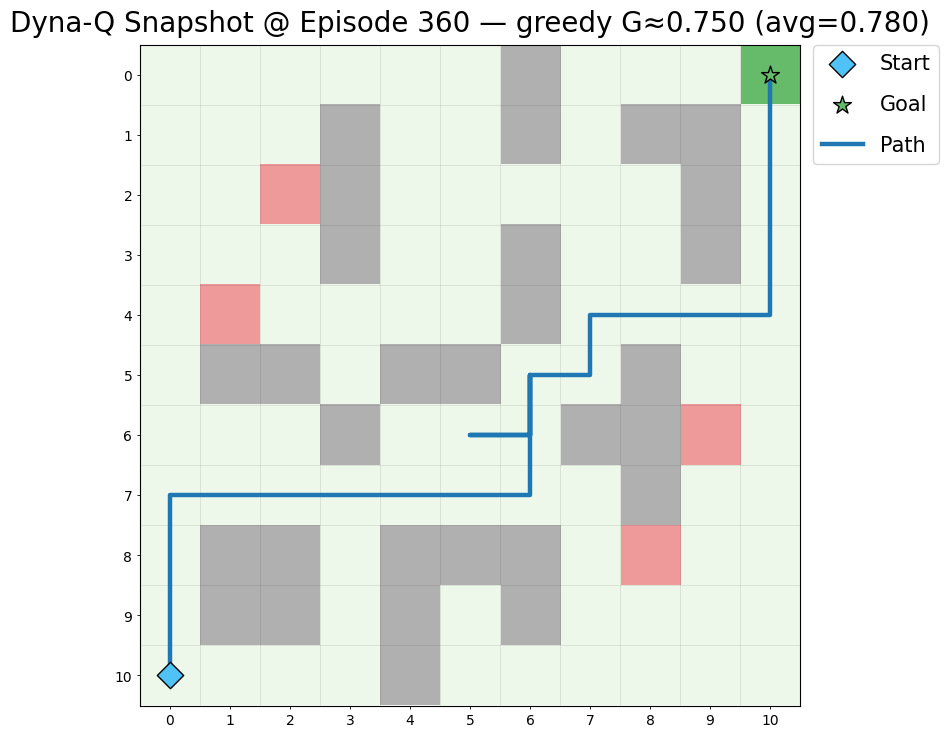

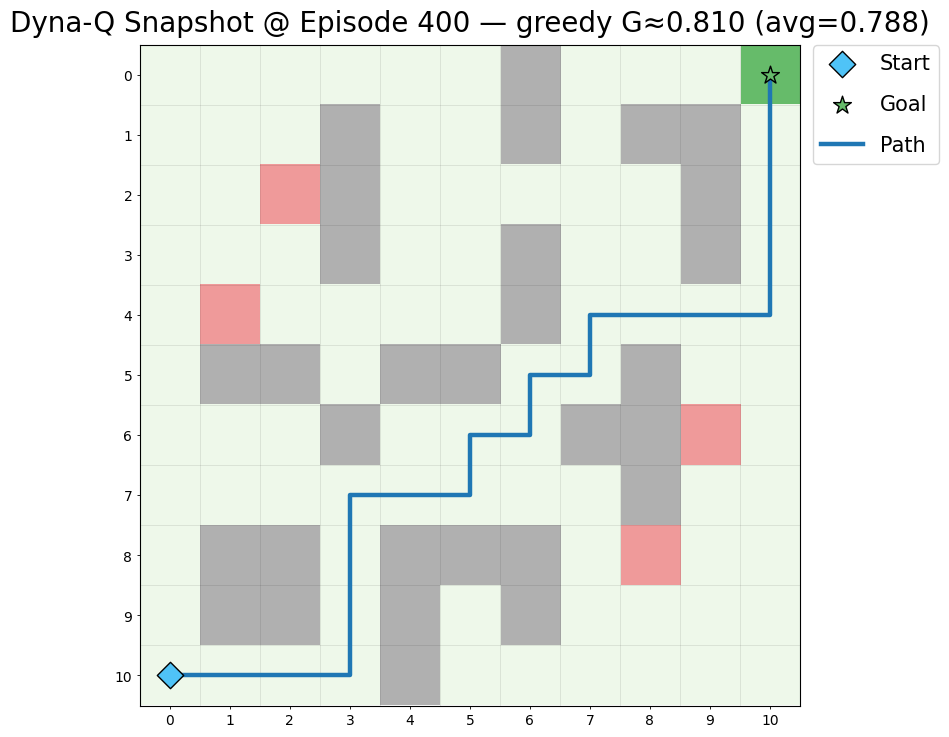

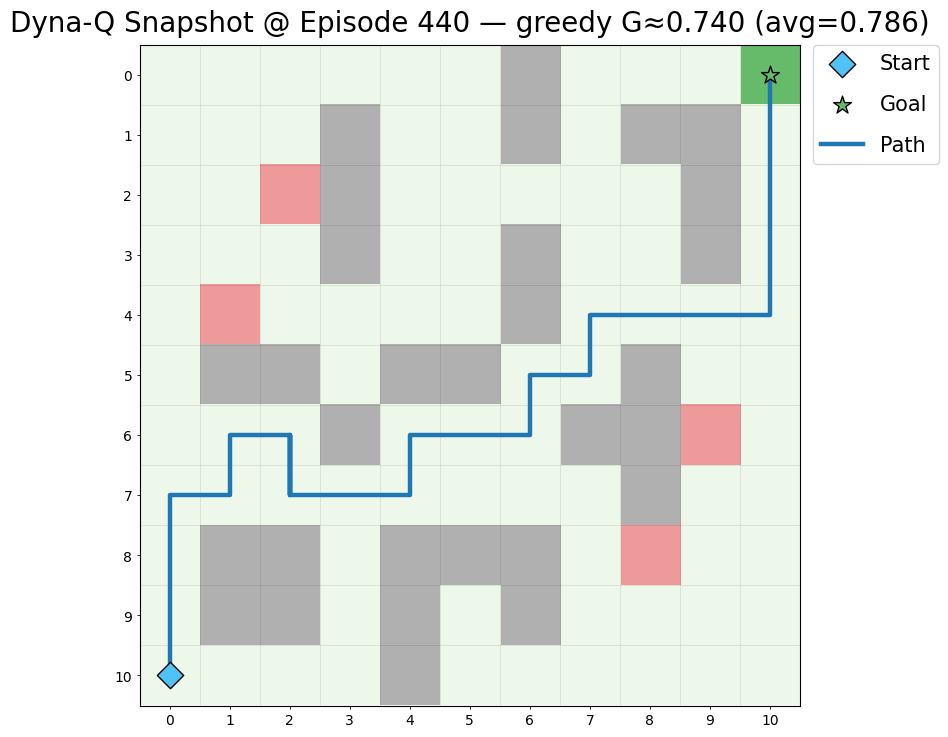

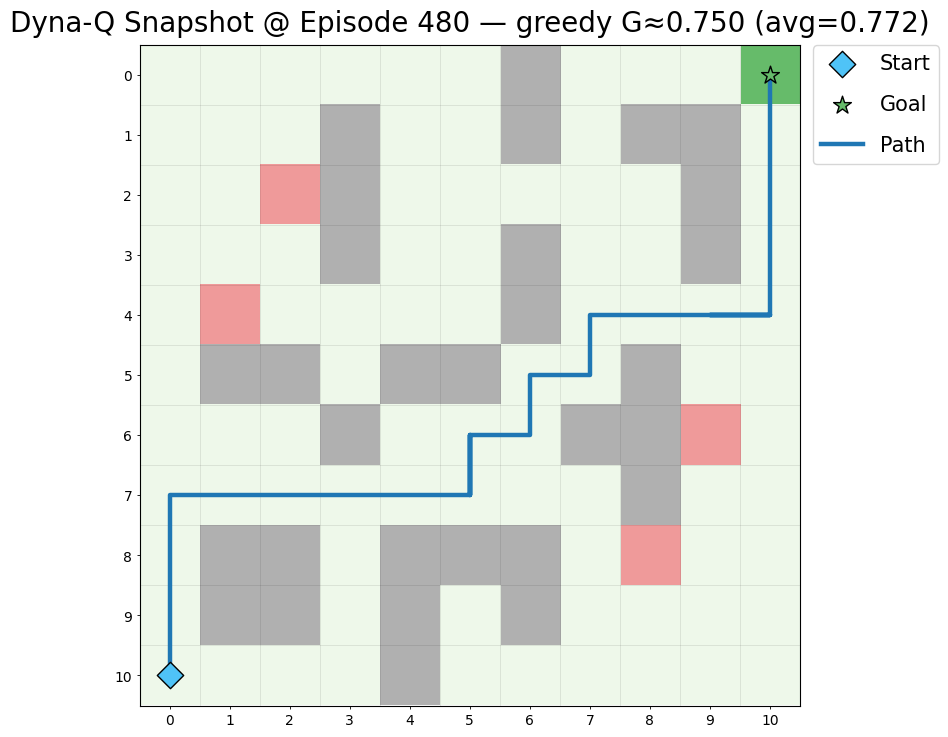

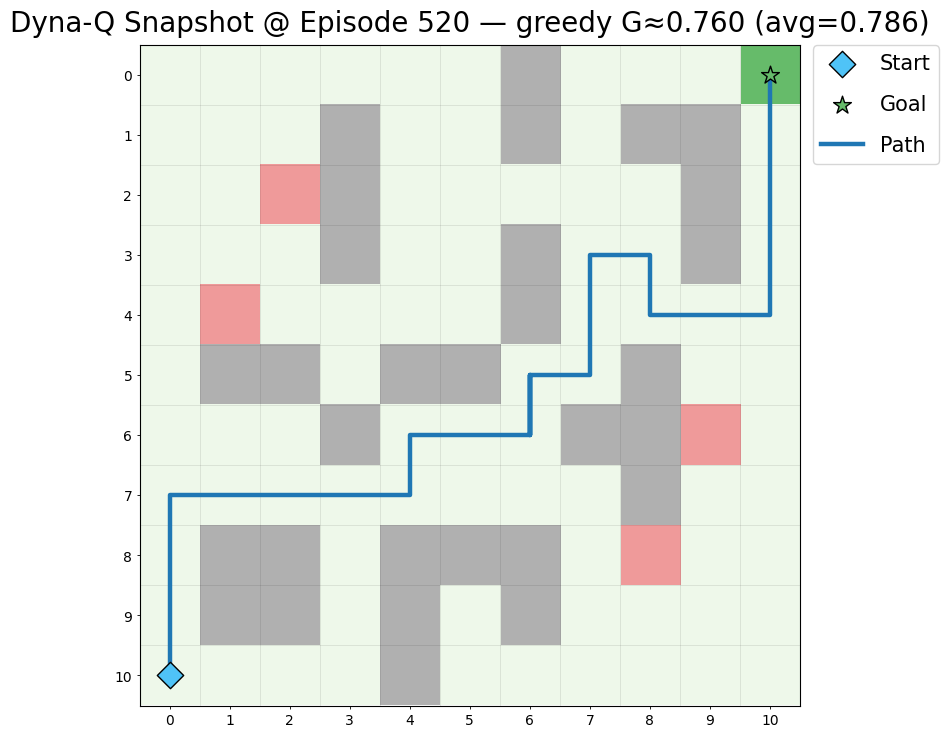

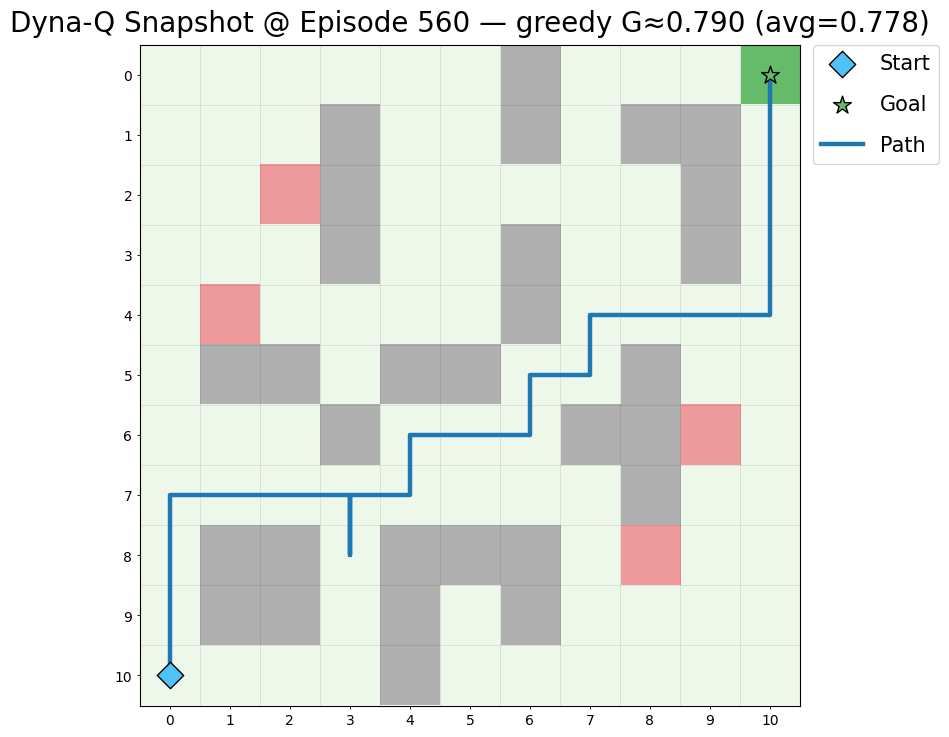

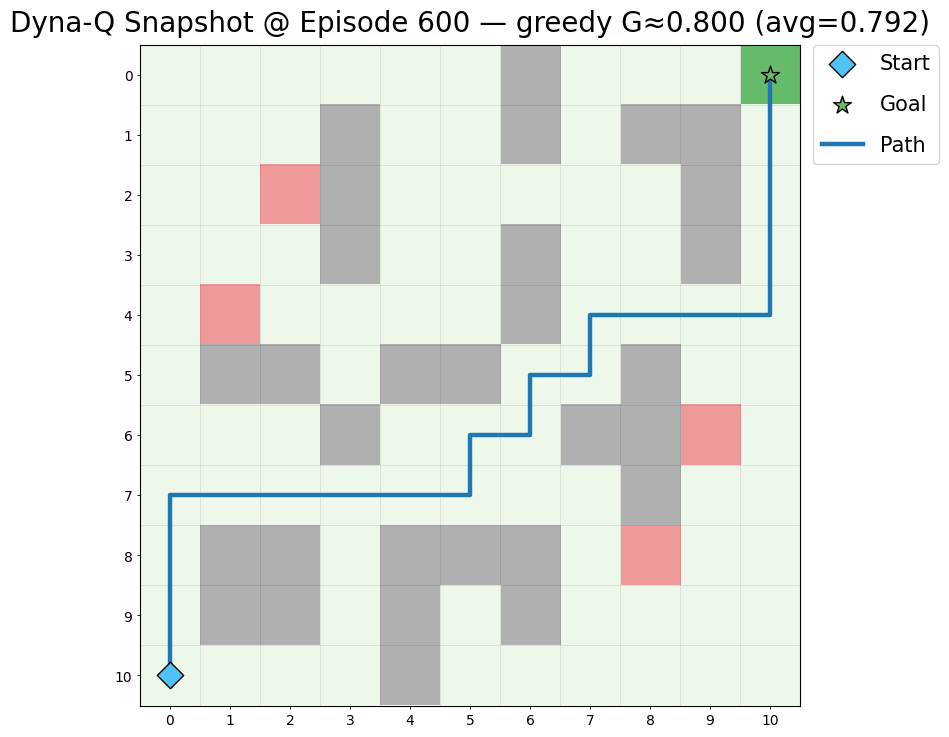

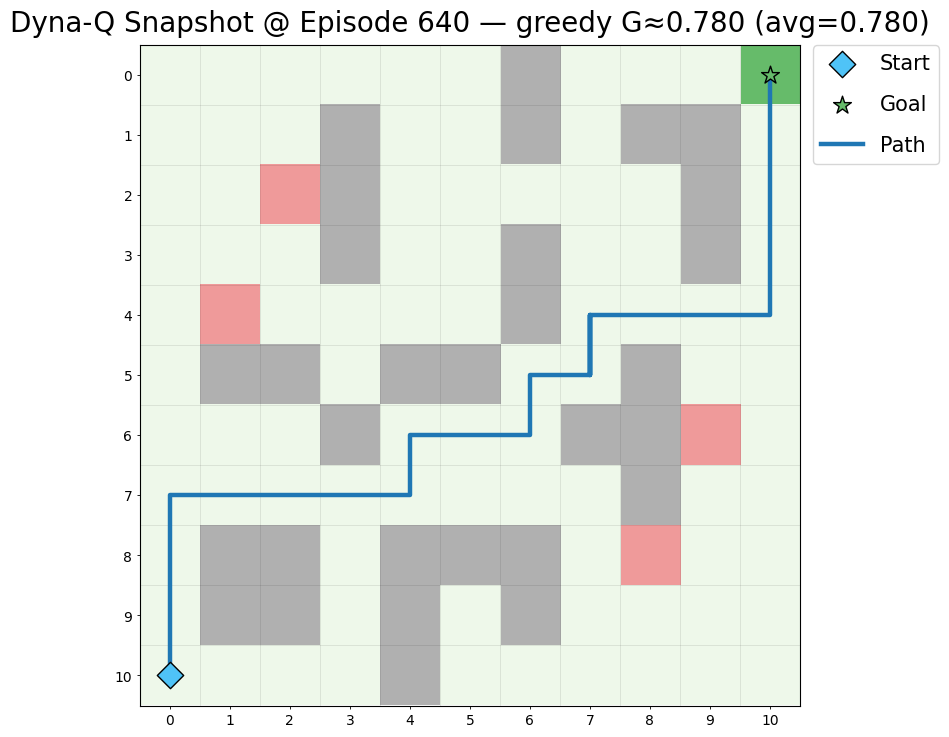

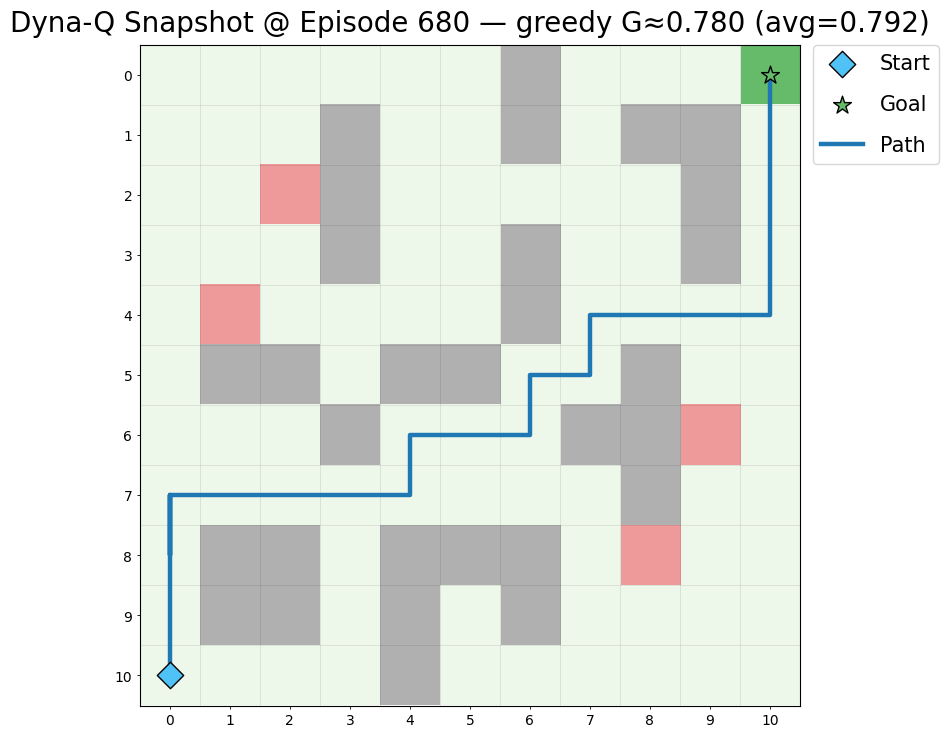

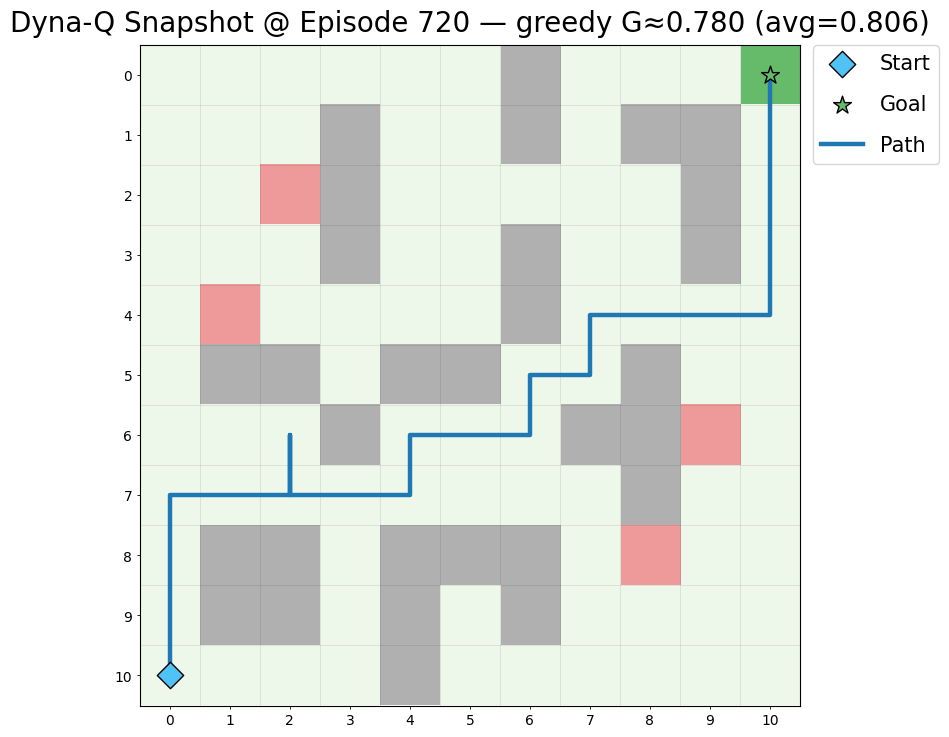

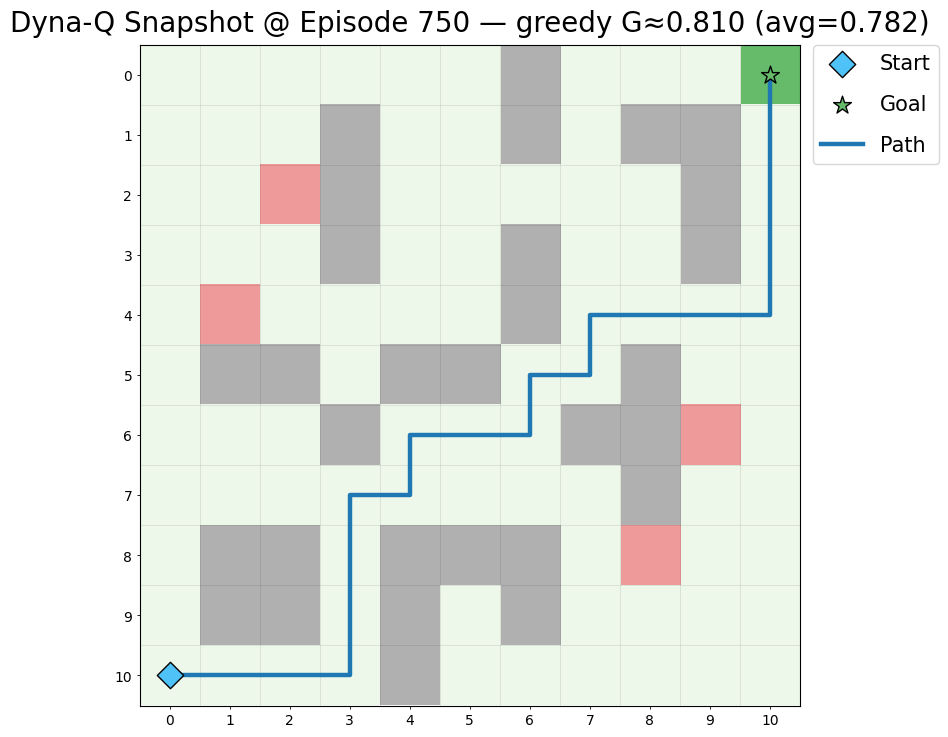

In [14]:
# Snapshots
for snap in logs_dyna["snapshots"]:
    ep = snap["episode"];
    Q_snap = snap["Q"];
    avg_ret = snap["avg_return"]

    # Run one greedy episode from this snapshot
    G_snap, traj_idx = run_greedy_episode(env, Q_snap, max_steps=cfg.max_steps)
    path_rc = idx_traj_to_rc_path(env, traj_idx)
    
    env.reset()
    env.render(
        path=path_rc,
        show_agent=False,
        title=f"Dyna-Q Snapshot @ Episode {ep} — greedy G≈{G_snap:.3f} (avg={avg_ret:.3f})"
    )

## 6) Final Path
This section prints the last outcome from the algorithm, showing the "most" optimal output. It provides the average `result` and `steps` the agent took during the algorithm.

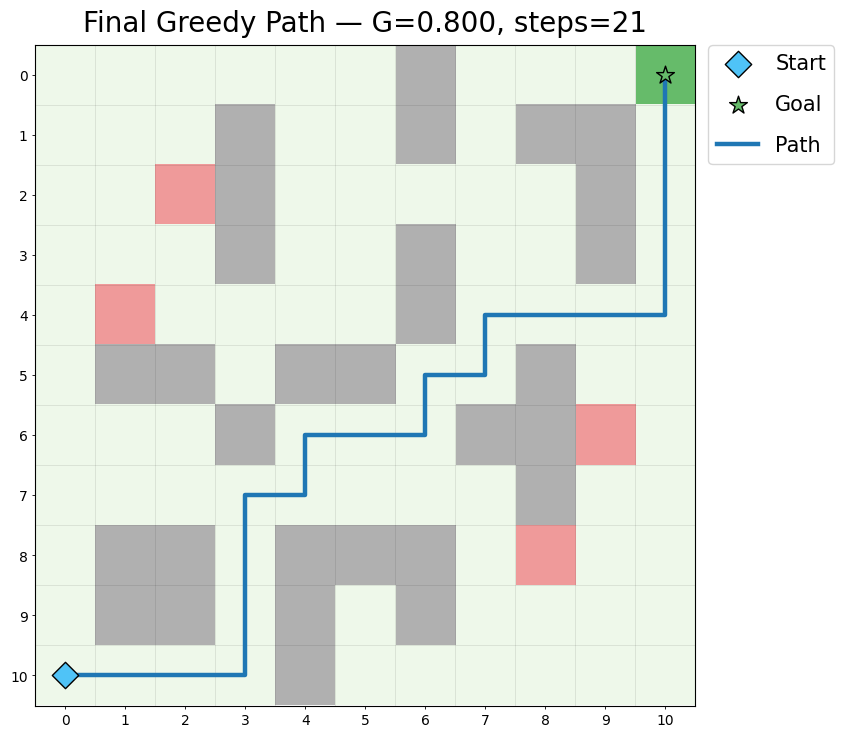

In [15]:
# Final Optimal Greedy Path
G_final, traj_final = run_greedy_episode(env, Q_dyna, max_steps=cfg.max_steps)
env.reset()
env.render(
    path=idx_traj_to_rc_path(env, traj_final),
    show_agent=False,
    title=f"Final Greedy Path — G={G_final:.3f}, steps={len(traj_final)-1}"
)

## 7) Policy / Value heatmap with arrows

Heat maps are used to visualize what is the trajectory that the agent took the most in order to find the "most" optimal greedy path.

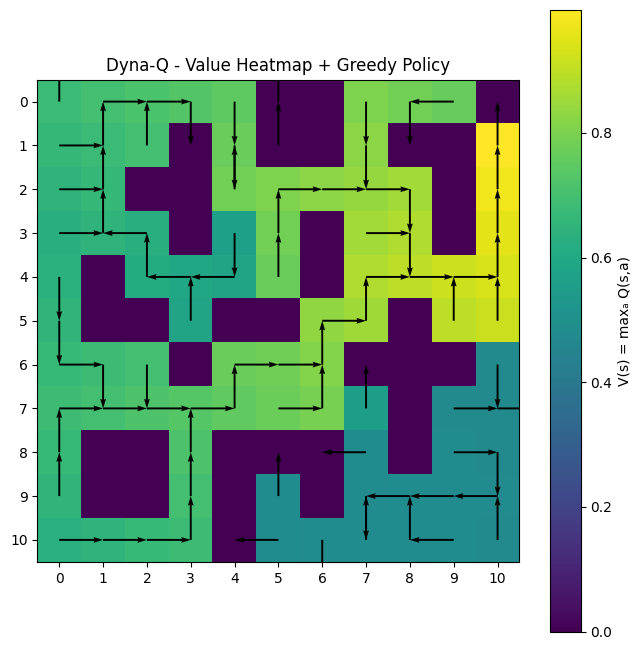

In [16]:
# Final Q_learning Visualization heatmap
plot_value_and_policy(env, Q_dyna, title="Dyna-Q - Value Heatmap + Greedy Policy")

### Conclusion


The results highlight Dyna-Q’s defining strength as a **model-based extension** of Q-Learning that accelerates learning through simulated experience. By combining real interactions with planning updates drawn from a learned one-step model, the agent refines its policy more rapidly and achieves higher early performance than either purely model-free method.

* **Episodic Return:** Initial episodes again show strongly negative returns as the agent explores blindly. However, the learning curve for Dyna-Q rises **significantly faster** than in SARSA or Q-Learning, reflecting the benefit of additional planning updates that reinforce valuable state–action pairs even without new environmental samples. The rolling-average return stabilizes sooner, indicating that the model’s replayed transitions effectively bootstrap knowledge across similar states.

* **Episode Length:** Episode duration decreases sharply after roughly **60–80 episodes**, a much earlier improvement than observed for the other algorithms. This shows that the agent not only reaches the goal more consistently but also optimizes its route more efficiently. The reduction in episode length plateaus as the model converges, suggesting diminishing returns once most useful transitions are already captured in memory.

* **Final Policy and Value Function:** The learned value heatmap displays a **well-structured gradient** toward the goal, with clearly delineated high-value corridors that avoid pits and walls. The greedy policy arrows align into a smooth, direct path from the start to the goal region. Unlike SARSA’s slightly conservative strategy, Dyna-Q’s policy more closely resembles the **aggressive optimal** path discovered by Q-Learning, but it is achieved in far fewer real episodes thanks to its internal planning.

* **Greedy Path Visualization:** The final greedy trajectory confirms that the agent reaches the goal in approximately **20–25 steps** with average returns near **0.8–0.9**, depending on environmental stochasticity. Movements appear confident and well-coordinated, rarely backtracking or stalling. This demonstrates Dyna-Q’s hallmark feature: by integrating **model learning and simulated updates**, the agent achieves **high sample efficiencyv**, learning near-optimal behavior with substantially fewer real environment interactions than purely model-free algorithms.

---

<style>
    .button {
        background-color: #3b3b3b;
        color: white;
        padding: 25px 60px;
        border: none;
        border-radius: 12px;
        cursor: pointer;
        font-size: 30px;
        transition: background-color 0.3s ease;
    }

    .button:hover {
        background-color: #45a049;
        transform: scale(1.05);
    }
    
</style>

<div style=" text-align: center; margin-top:20px;">
    
  <a href="02_sarsa.ipynb">
    <button class="button">
      ⬅️ Prev: SARSA
    </button>
  </a>
  <span style="display:inline-block; width:200px;"></span>
  <a href="04_comparison_models.ipynb">
    <button class="button">
      Next: Model Comparison ➡️
    </button>
  </a>
  
</div>
